# <b> Preparing Data for Models </b>
___

<b> Table of Content: </b>
<br> [0. Loading Modules and Dataset](#11)
<br> [1. Outlier IQR](#22)
<br> [2. Normalization](#33)
<br> [3. Standardization Z-score](#44)
<br> [4. Correlation Analysis](#55)
<br> [5. Save Top Features and Target to a CSV File](#66)

<a id = "11"> <h2> 0. Loading Modules and Dataset </h2> </a>
___

<b> Import modules

In [45]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm
from scipy.stats import kurtosis, skew
from scipy.stats import boxcox
from scipy.stats import zscore

from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge

from sklearn.linear_model import LogisticRegression
from sklearn import datasets

import warnings


<b> Read previously recoded/calculated features from a .csv file to a pandas dataframe

In [2]:
df = pd.read_csv("census_covid_cat_final.csv")
df.head()

,Full Name,Country Name,State,State Abbr,Total Population,Households SNAP,Estimated Individuals SNAP,Total Citizen Educated in US,Citizen Less than High School Education,Citizen High School Graduate,...,Female Median Age,Total Households,Average Household Size,Total Families,Total Confirmed Cases,Total Deaths,Case Rate per 1000,Death Rate 1000,Case Rate Categories,Death Rate Categories
0,"Autauga County, Alabama",Autauga County,Alabama,AL,54571,2802,7509,36757,4521,12363,...,37.9,20221,3,14613,0,0,7.330,0.147,2,2
1,"Baldwin County, Alabama",Baldwin County,Alabama,AL,182265,6644,16344,143022,13997,39771,...,42.2,73180,2,41898,400,8,2.200,0.049,2,1
2,"Barbour County, Alabama",Barbour County,Alabama,AL,27457,2468,6096,18434,4960,6549,...,41.6,9820,2,6015,401,9,9.579,0.036,3,1
3,"Bibb County, Alabama",Bibb County,Alabama,AL,22915,933,2426,15859,2833,6958,...,39.5,7953,3,5201,263,1,5.280,0.044,2,1
4,"Blount County, Alabama",Blount County,Alabama,AL,57322,2244,5902,39475,7980,12740,...,40.0,21578,3,14106,121,1,2.268,0.017,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 43 columns):
Full Name                                     3139 non-null object
Country Name                                  3139 non-null object
State                                         3139 non-null object
State Abbr                                    3139 non-null object
 Total Population                             3139 non-null int64
 Households SNAP                              3139 non-null int64
 Estimated Individuals SNAP                   3139 non-null int64
 Total Citizen Educated in US                 3139 non-null int64
 Citizen Less than High School  Education     3139 non-null int64
 Citizen High School  Graduate                3139 non-null int64
 Citizen Some College  Education              3139 non-null int64
 Citizen College Degree                       3139 non-null int64
 Citizen Graduate or Professional Degree      3139 non-null int64
 Total Citizen Income          

In [4]:
# show the list of features incl. target in dataset
#df.columns.to_series().groupby(df.dtypes).groups

In [5]:
# trim the spaces of the cells from the csv file
df.columns = df.columns.to_series().apply(lambda x: x.strip())

<a id = "22"> <h2> 1. Outlier IQR </h2> </a>
___

<b> Assumption: </b> Every data point for every continuous feature that is 1.5 times below/above the Interquartile Range (Q3-Q1) is considered an outlier
<br> Whereby zero's are excluded from the calculation of the 25% quantile and 75% quantile

The features in the table above, should not be included in dealing with outliers with the IQR method, it will result in all zero's

<b> 1.1 Create a function to deal with outliers </b>

In [6]:
def remove_cols_outliers_iqr(df, column_list): 
    for my_col in column_list:      
        # only calculate the quantile on non-zero values in the column
        Q1 = df[df[my_col] > 0 ][my_col].quantile(0.25)
        Q3 = df[df[my_col] > 0 ][my_col].quantile(0.75)
        #Q1 = df[my_col].quantile(0.25)
        #Q3 = df[my_col].quantile(0.75)
        IQR = Q3 - Q1

        u_bound_q3 = (Q3 + 1.5 * IQR)
        l_bound_q1 = (Q1 - 1.5 * IQR)
        
        # combine old column name with a suffix for the new name of the column
        suffix = '_iqr'
        my_new_col = ''.join([my_col, suffix])
        
        # create a new column with the name: (column name + suffix)
        df[my_new_col] = df[my_col]
        
        # if a value in the column is larger than the upper bound, set it equal to the upper bound, else keep the original value
        df[my_new_col] = np.where(df[my_new_col] > u_bound_q3, u_bound_q3, df[my_new_col]) 
        # if a value in the column is larger than the lower bound, set it equal to the lower bound, else keep the original value
        df[my_new_col] = np.where(df[my_new_col] < l_bound_q1, l_bound_q1, df[my_new_col]) 

<b> 1.2 Apply the function  on continuous features </b>

In [7]:
# create a list of the continuous features in the pandas dataframe
lst_continuous_cols = ['Total Population','Households SNAP','Estimated Individuals SNAP','Total Citizen Educated in US',
                       'Citizen Less than High School  Education','Citizen High School  Graduate',
                       'Citizen Some College  Education','Citizen College Degree','Citizen Graduate or Professional Degree',
                       'Total Citizen Income','Citizen No Income','Citizen Income 1-9999','Citizen Income 10000-14999',
                       'Citizen Income 15000-24999','Citizen Income 25000-34999','Citizen Income 35000-49999',
                       'Citizen Income 50000-64999','Citizen Income 65000-74999','Citizen Income over 75000',
                       'One Race Population','White Race','Black Race','Native American Race','Asian Race',
                       'Pacific Islander Race','Other Race Alone','Hispanic or Latino','Median Age', 
                        'Male Median Age','Female Median Age','Total Households',
                       'Average Household Size','Total Families', 'Total Confirmed Cases', 'Total Deaths',
                      'Case Rate per 1000', 'Death Rate 1000']


# apply the function to the list of continuous features        
remove_cols_outliers_iqr(df=df, column_list=lst_continuous_cols) 

_test if all iqr columns were created:_

In [8]:
# source: https://stackoverflow.com/questions/21285380/find-column-whose-name-contains-a-specific-string
iqr_cols = [col for col in df.columns if 'iqr' in col]

# test if the length of the list of columns that has iqr in the name, is the same length as the list provided in the function of column names
len(lst_continuous_cols) == len(iqr_cols)

# show columns where names contains the string 'iqr'
iqr_cols

['Total Population_iqr',
 'Households SNAP_iqr',
 'Estimated Individuals SNAP_iqr',
 'Total Citizen Educated in US_iqr',
 'Citizen Less than High School  Education_iqr',
 'Citizen High School  Graduate_iqr',
 'Citizen Some College  Education_iqr',
 'Citizen College Degree_iqr',
 'Citizen Graduate or Professional Degree_iqr',
 'Total Citizen Income_iqr',
 'Citizen No Income_iqr',
 'Citizen Income 1-9999_iqr',
 'Citizen Income 10000-14999_iqr',
 'Citizen Income 15000-24999_iqr',
 'Citizen Income 25000-34999_iqr',
 'Citizen Income 35000-49999_iqr',
 'Citizen Income 50000-64999_iqr',
 'Citizen Income 65000-74999_iqr',
 'Citizen Income over 75000_iqr',
 'One Race Population_iqr',
 'White Race_iqr',
 'Black Race_iqr',
 'Native American Race_iqr',
 'Asian Race_iqr',
 'Pacific Islander Race_iqr',
 'Other Race Alone_iqr',
 'Hispanic or Latino_iqr',
 'Median Age_iqr',
 'Male Median Age_iqr',
 'Female Median Age_iqr',
 'Total Households_iqr',
 'Average Household Size_iqr',
 'Total Families_iqr',


<b> 1.3 Test if the function correctly worked, using different examples </b>

_test if the maximum changed_

In [9]:
print('maximum value of feature `Total Population`:', df['Total Population'].max())
print('new maximum value after removal of outliers with iqr of feature `Total Population_iqr`:', df['Total Population_iqr'].max())


maximum value of feature `Total Population`: 9818605
new maximum value after removal of outliers with iqr of feature `Total Population_iqr`: 150073.5


In [10]:
# show the original feature versus the feature where outliers are dealt with using IQR
df[df['Total Population_iqr']==54571][['Total Population', 'Total Population_iqr']]

,Total Population,Total Population_iqr
0,54571,54571.0


<a id = "33"> <h2> 2. Normalization </h2> </a>
___

Assumption: the dataset follows a Gaussian Distribution

<b> 2.2 Create a function to normalize continuous features with a PowerTransform: </b>
<br> using Boxcox _(for Positive Features)_ 
<br> <b> Note: </b> A power transformation will change the distribution of the data, for more information see: [link](https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712)

In [11]:
################################################################################################ 
# defined a function to normalize a feature in an additional new column with powertransform, 
# using boxcox (if positive values) 
# and add a suffix to the name of the column _bc for boxcox 
################################################################################################ 
# required modules -> imported at the start but if you copy/paste this function please make sure you install the two below!
#from scipy.stats import boxcox


def powertransform_boxcox_yeojohnson(df, column_list):
    # loop through each column in the column list
    for my_col in column_list:      
        # test if the minimum in the column is positive, if True apply boxcox, if False apply yeojohnson
        if (df[my_col].min() > 0)==True:
            # combine old column name with a suffix for the new name of the column
            suffix = '_bc'
            my_new_col = ''.join([my_col, suffix])
            # create a new column with the name: (column name + suffix)
            df[my_new_col] = df[my_col]
            # if positive, apply boxcox
            df[my_new_col] = boxcox(df[my_new_col])[0]

<b> 2.3 Apply the function to normalize continuous features
1. Applied to continuous features <b> without </b>  applying outlier IQR,
2. Applied to continuous features <b> with </b> applying outlier IQR:

In [12]:
# list continuous features
lst_continuous_cols = ['Total Population_iqr',
                             'Households SNAP_iqr',
                             'Estimated Individuals SNAP_iqr',
                             'Total Citizen Educated in US_iqr',
                             'Citizen Less than High School  Education_iqr',
                             'Citizen High School  Graduate_iqr',
                             'Citizen Some College  Education_iqr',
                             'Citizen College Degree_iqr',
                             'Citizen Graduate or Professional Degree_iqr',
                             'Total Citizen Income_iqr',
                             'Citizen No Income_iqr',
                             'Citizen Income 1-9999_iqr',
                             'Citizen Income 10000-14999_iqr',
                             'Citizen Income 15000-24999_iqr',
                             'Citizen Income 25000-34999_iqr',
                             'Citizen Income 35000-49999_iqr',
                             'Citizen Income 50000-64999_iqr',
                             'Citizen Income 65000-74999_iqr',
                             'Citizen Income over 75000_iqr',
                             'One Race Population_iqr',
                             'White Race_iqr',
                             'Black Race_iqr',
                             'Native American Race_iqr',
                             'Asian Race_iqr',
                             'Pacific Islander Race_iqr',
                             'Other Race Alone_iqr',
                             'Hispanic or Latino_iqr',
                            'Median Age_iqr',
                             'Male Median Age_iqr',
                             'Female Median Age_iqr',
                             'Total Households_iqr',
                             'Average Household Size_iqr',
                             'Total Families_iqr',
                             'Total Confirmed Cases_iqr',
                             'Total Deaths_iqr',
                             'Case Rate per 1000_iqr',
                             'Death Rate 1000_iqr']

powertransform_boxcox_yeojohnson(df=df, column_list=lst_continuous_cols)

<b> 2.4 Test if there are NaN's after the normalization

In [13]:
# check if there are NaN's after the normalization
# create a function to create a dataframe with # NaN's and % NaN's
def function_nans(df):
    # Count NaN's
    list_nan = df.isna().sum()

    # Percentage of missing values for each column (To see the amount of usable data for each column and infer the effect replacing NaN's will have by some metric in part 2)
    list_nan_pct = df.isna().mean().round(4) * 100

    # create a dataframe showing the missing and percentage that is missing
    df_combined = pd.concat([list_nan.rename('# NaNs'), list_nan_pct.rename('% NaNs')], axis=1)
    
    #return(df_combined)
    return(df_combined[df_combined['# NaNs']>0])

# show all the rows of the dataframe without truncating
#pd.set_option('display.max_rows', len(df))

# apply function 'function_nans' - show a dataframe for number of NaN's and the % of NaN's for each added feature
function_nans(df=df)
# conclusion, no NaN's, because empty dataframe

,# NaNs,% NaNs


<b> 2.5 Test if all normalized features are added to the dataframe

Test if additional columns were created with boxcox, using a suffix _bc

In [14]:
bc_cols = [col for col in df.columns if '_bc' in col]
# show columns where names contains the string '_bc'
bc_cols

['Total Population_iqr_bc',
 'Total Citizen Educated in US_iqr_bc',
 'Citizen Less than High School  Education_iqr_bc',
 'Citizen High School  Graduate_iqr_bc',
 'Citizen Some College  Education_iqr_bc',
 'Citizen College Degree_iqr_bc',
 'Total Citizen Income_iqr_bc',
 'Citizen No Income_iqr_bc',
 'Citizen Income 1-9999_iqr_bc',
 'Citizen Income 10000-14999_iqr_bc',
 'Citizen Income 15000-24999_iqr_bc',
 'Citizen Income 25000-34999_iqr_bc',
 'Citizen Income 35000-49999_iqr_bc',
 'Citizen Income 50000-64999_iqr_bc',
 'Citizen Income over 75000_iqr_bc',
 'One Race Population_iqr_bc',
 'Other Race Alone_iqr_bc',
 'Hispanic or Latino_iqr_bc',
 'Median Age_iqr_bc',
 'Male Median Age_iqr_bc',
 'Female Median Age_iqr_bc',
 'Total Households_iqr_bc',
 'Average Household Size_iqr_bc']

Test if additional columns were created with a suffix _yj

In [15]:
# set the option to not truncate the columns when showing a dataframe
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')
df.head()

,Full Name,Country Name,State,State Abbr,Total Population,Households SNAP,Estimated Individuals SNAP,Total Citizen Educated in US,Citizen Less than High School Education,Citizen High School Graduate,Citizen Some College Education,Citizen College Degree,Citizen Graduate or Professional Degree,Total Citizen Income,Citizen No Income,Citizen Income 1-9999,Citizen Income 10000-14999,Citizen Income 15000-24999,Citizen Income 25000-34999,Citizen Income 35000-49999,Citizen Income 50000-64999,Citizen Income 65000-74999,Citizen Income over 75000,One Race Population,White Race,Black Race,Native American Race,Asian Race,Pacific Islander Race,Other Race Alone,Hispanic or Latino,Median Age,Male Median Age,Female Median Age,Total Households,Average Household Size,Total Families,Total Confirmed Cases,Total Deaths,Case Rate per 1000,Death Rate 1000,Case Rate Categories,Death Rate Categories,Total Population_iqr,Households SNAP_iqr,Estimated Individuals SNAP_iqr,Total Citizen Educated in US_iqr,Citizen Less than High School Education_iqr,Citizen High School Graduate_iqr,Citizen Some College Education_iqr,Citizen College Degree_iqr,Citizen Graduate or Professional Degree_iqr,Total Citizen Income_iqr,Citizen No Income_iqr,Citizen Income 1-9999_iqr,Citizen Income 10000-14999_iqr,Citizen Income 15000-24999_iqr,Citizen Income 25000-34999_iqr,Citizen Income 35000-49999_iqr,Citizen Income 50000-64999_iqr,Citizen Income 65000-74999_iqr,Citizen Income over 75000_iqr,One Race Population_iqr,White Race_iqr,Black Race_iqr,Native American Race_iqr,Asian Race_iqr,Pacific Islander Race_iqr,Other Race Alone_iqr,Hispanic or Latino_iqr,Median Age_iqr,Male Median Age_iqr,Female Median Age_iqr,Total Households_iqr,Average Household Size_iqr,Total Families_iqr,Total Confirmed Cases_iqr,Total Deaths_iqr,Case Rate per 1000_iqr,Death Rate 1000_iqr,Total Population_iqr_bc,Total Citizen Educated in US_iqr_bc,Citizen Less than High School Education_iqr_bc,Citizen High School Graduate_iqr_bc,Citizen Some College Education_iqr_bc,Citizen College Degree_iqr_bc,Total Citizen Income_iqr_bc,Citizen No Income_iqr_bc,Citizen Income 1-9999_iqr_bc,Citizen Income 10000-14999_iqr_bc,Citizen Income 15000-24999_iqr_bc,Citizen Income 25000-34999_iqr_bc,Citizen Income 35000-49999_iqr_bc,Citizen Income 50000-64999_iqr_bc,Citizen Income over 75000_iqr_bc,One Race Population_iqr_bc,Other Race Alone_iqr_bc,Hispanic or Latino_iqr_bc,Median Age_iqr_bc,Male Median Age_iqr_bc,Female Median Age_iqr_bc,Total Households_iqr_bc,Average Household Size_iqr_bc
0,"Autauga County, Alabama",Autauga County,Alabama,AL,54571,2802,7509,36757,4521,12363,10697,5316,3860,44109,6377,6955,4235,6000,4825,5727,3352,1340,5298,42855,9643,232,474,32,466,869,53261,37.0,35.9,37.9,20221,3,14613,0,0,7.330,0.147,2,2,54571.0,2802.0,7509.0,36757.0,4521.0,12363.0,10697.00,5316.0,3860.000,44109.00,6377.0,6955.0,4235.00,6000.0,4825.0,5727.00,3352.0,1340.00,5298.0,42855.00,9643.0,232.000,474.0,32.0,466.0,869.0,53261.00,37.0,35.9,37.9,20221.0,3.0,14613.00,0.0,0.0,7.330,0.147,25.393962,23.030193,24.630089,24.000518,16.479497,11.490486,23.869015,23.328267,18.421893,18.524565,17.581352,15.722328,15.576571,12.915181,11.724161,25.614632,9.789879,27.852099,59.875297,29.414196,125.477485,20.314439,0.485672
1,"Baldwin County, Alabama",Baldwin County,Alabama,AL,182265,6644,16344,143022,13997,39771,45286,29237,14731,166364,20201,25080,16030,26852,20222,21502,13466,5057,17954,156153,17105,1216,1348,89,3631,2723,174273,41.1,40.1,42.2,73180,2,41898,400,8,2.200,0.049,2,1,150073.5,6644.0,16344.0,103114.0,12942.5,33918.0,32031.75,14823.0,8459.125,124000.25,16089.5,22224.0,12056.25,19035.0,14998.5,15660.25,10333.0,4120.25,11040.0,126090.75,13646.5,1123.375,1348.0,89.0,3631.0,2723.0,140466.75,41.1,40.1,42.2,57984.0,2.0,34798.25,400.0,8.0,2.200,0.049,30.283200,27.544206,32.281033,29.739068,19.840588,13.344409,28.533103,28.987045,23.185884,23.295029,22.077047,19.509204,18.731187,15.760823,13.091283,31.147157,12.226061,33.325527,67.920227,32.739371,1

### 2.6 Visualize the original features (incl. imputed outliers with IQR) versus the normalized features
___

<b> 2.6.1 Create a function to make subplots/histograms of a list of columns from a pandas dataframe

In [16]:
def hist_subplots(df, col_list):   
    ############################
    # Define variables
    ############################
    # set counter for for-loop
    i = 1
    # set the rows of the subplots
    nrows = int(len(col_list)/4)
    # set the columns of the subplots
    ncols = 4
   
    ############################
    # make the figure before 
    # populating it with data
    ############################
    fig, ax = plt.subplots(nrows,ncols)
    
    ############################
    # layout options
    ############################
    # set the style
    # reference: https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
    #plt.style.use('fivethirtyeight')
    # set the figure size
    ## height
    fig.set_figheight(3*nrows)
    ## width
    fig.set_figwidth(15)
    ## set tight layout
    fig.tight_layout(pad=1, w_pad=0.1, h_pad=1)
    # adjust relative positions of subplots
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.25)
    # set title (first part bold and second part on newline not-bold)
    fig.suptitle(r"$\bf{Continuous\ Features\ }$" + '\n Before and After Normalization', y=0.95, fontsize=16)
    
    ############################
    # Loop through each subplot
    ############################
    # flatten the axis
    ax = ax.flatten()
    
    for i, col in enumerate(df[col_list]):
        
        # set color based on even number or uneven of i (if even number -> green, if odd number -> red)
        if (i % 2) == 0:
            # set color for even numbers
            color_hist = 'g'
        else:
            # set color for uneven numbers
            color_hist = 'r'
        
        # calculate the average (mu) and standard deviation (std)
        mu, std = norm.fit(df[col])
        skewness = skew(df[col])
        
        # plot the histogram for the subplot
        ax[i].hist(df[col], bins=25, density=False, alpha=0.8, color=color_hist)
       
        # Get part of the title in bold letters and another part normal - using matplotlib mathtext syntax bold letters => (r"$\bf{" + str(title_name) + "}$")
        # first convert title name to mathtext - take care of special characters with escape sign
        # without this piece of code, the title of the subplot, which is the columnane, would mess up the underscore sign and interpret it as a math symbol and would not take care of spaces correctly between words
        escaped_string = col.translate(str.maketrans({"_": r"\_",
                                           " ": r"\ "}))

        # set the title of each subplot
        ax[i].set_title(label=(r"$\bf{" + str(escaped_string) + "}$" + '\n mu = %.2f,  std = %.2f, \n skewness = %.2f' % (mu, std, skewness)),  fontweight='normal', size=12) 

<b> 2.6.2 Apply the function to create subplots/histograms of the continuous features_

In [30]:
# define (pair-wise) list to plot histograms of, in the following sequence: 
# 1st the feature before normalization, 
# 2nd the feature after outlier removal (IQR)
# 3rd the feature after normalization etc

lst_continuous_cols = ['Total Population','Total Citizen Educated in US',
                       'Citizen Less than High School  Education','Citizen High School  Graduate',
                       'Citizen Some College  Education','Citizen College Degree','Citizen Graduate or Professional Degree',
                       'Total Citizen Income','Citizen No Income','Citizen Income 1-9999','Citizen Income 10000-14999',
                       'Citizen Income 15000-24999','Citizen Income 25000-34999','Citizen Income 35000-49999',
                       'Citizen Income 50000-64999','Citizen Income 65000-74999','Citizen Income over 75000',
                       'White Race','Black Race','Native American Race','Asian Race',
                       'Pacific Islander Race','Hispanic or Latino','Total Households',
                       'Average Household Size','Total Families', 'Total Confirmed Cases', 'Total Deaths',
                      'Case Rate per 1000', 'Death Rate 1000','Total Population_iqr','Total Citizen Educated in US_iqr',
                       'Citizen Less than High School  Education_iqr', 'Citizen High School  Graduate_iqr',
                        'Citizen Some College  Education_iqr','Citizen College Degree_iqr','Citizen Graduate or Professional Degree_iqr',
                        'Total Citizen Income_iqr','Citizen No Income_iqr','Citizen Income 1-9999_iqr',
                        'Citizen Income 10000-14999_iqr','Citizen Income 15000-24999_iqr','Citizen Income 25000-34999_iqr',
                       'Citizen Income 35000-49999_iqr','Citizen Income 50000-64999_iqr','Citizen Income 65000-74999_iqr',
                        'Citizen Income over 75000_iqr','White Race_iqr','Black Race_iqr',
                         'Native American Race_iqr', 'Asian Race_iqr','Pacific Islander Race_iqr',
                        'Hispanic or Latino_iqr','Median Age_iqr', 'Male Median Age_iqr', 
                       'Female Median Age_iqr','Total Households_iqr','Average Household Size_iqr',
                       'Total Families_iqr','Total Confirmed Cases_iqr','Total Deaths_iqr','Case Rate per 1000_iqr',
                       'Death Rate 1000_iqr', 'Total Population_iqr_bc',
                        'Total Citizen Educated in US_iqr_bc','Citizen Less than High School  Education_iqr_bc',
                        'Citizen High School  Graduate_iqr_bc','Citizen Some College  Education_iqr_bc',
                         'Citizen College Degree_iqr_bc','Total Citizen Income_iqr_bc','Citizen No Income_iqr_bc',
                          'Citizen Income 1-9999_iqr_bc','Citizen Income 10000-14999_iqr_bc','Citizen Income 15000-24999_iqr_bc',
                         'Citizen Income 25000-34999_iqr_bc','Citizen Income 35000-49999_iqr_bc',
                        'Citizen Income 50000-64999_iqr_bc','Citizen Income over 75000_iqr_bc',
                        'Hispanic or Latino_iqr_bc','Median Age_iqr_bc',
                         'Male Median Age_iqr_bc', 'Female Median Age_iqr_bc','Total Households_iqr_bc',
                       'Average Household Size_iqr_bc']

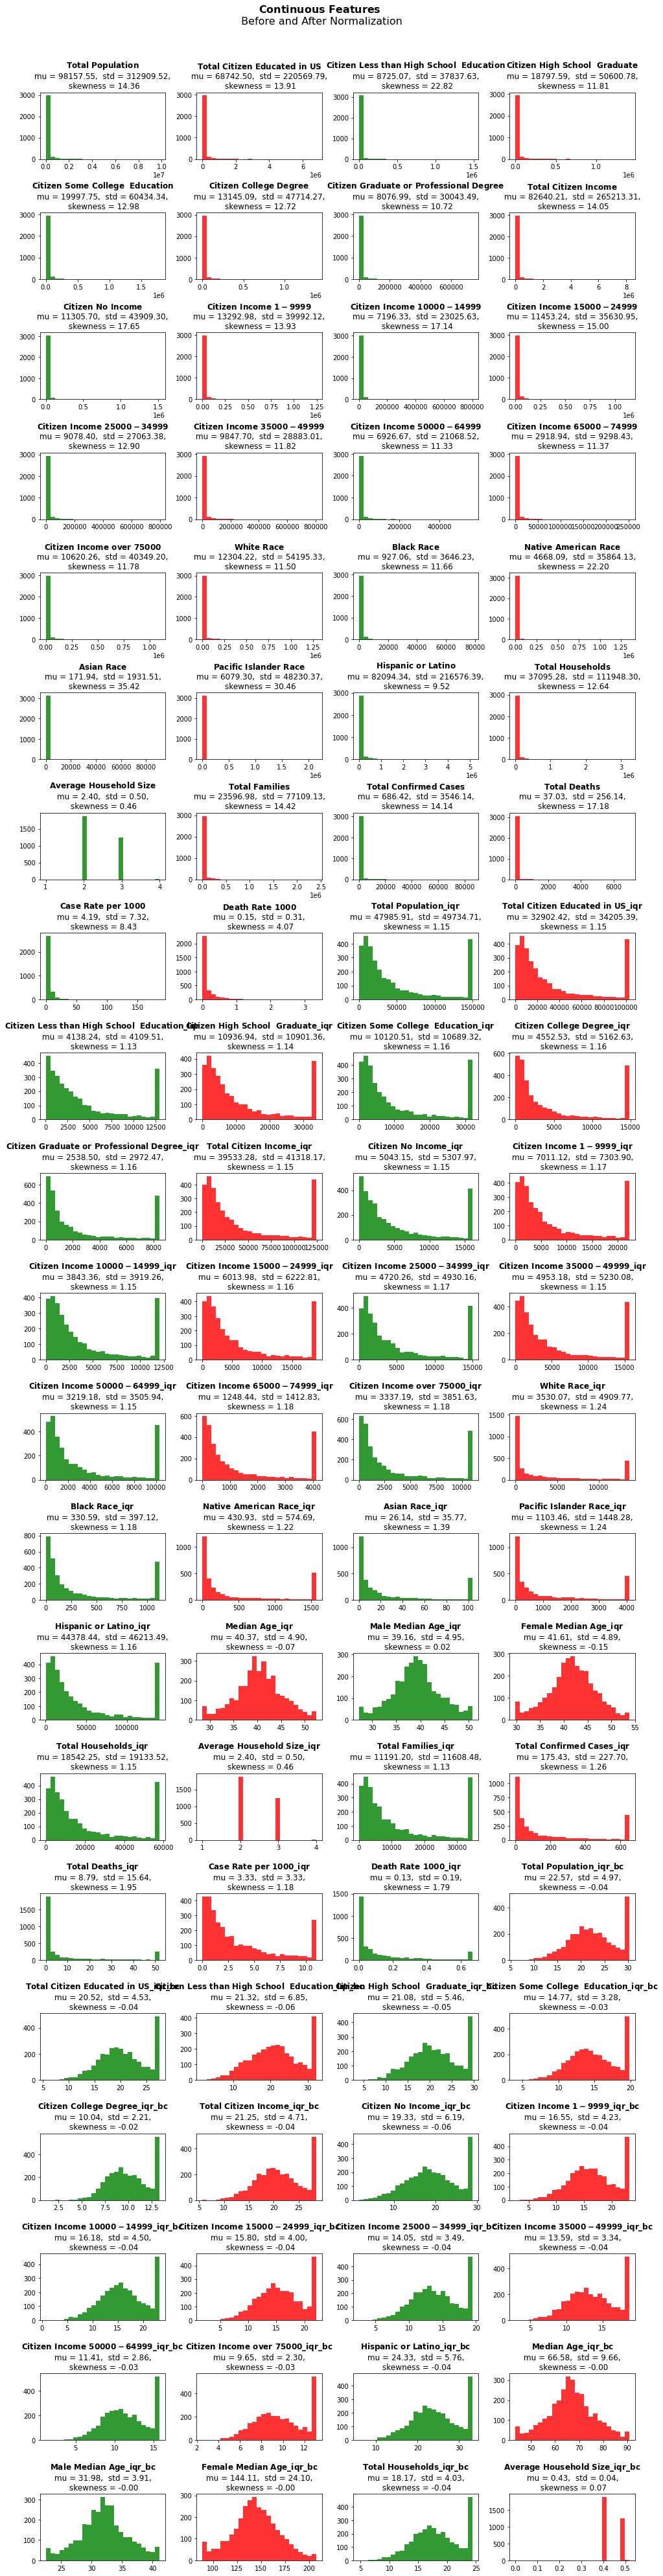

In [31]:
hist_subplots(df, lst_continuous_cols)

<b> 2.7 Skewness before and after the normalization

## Skewness ##
>* If skewness is less than −1 or greater than +1, the distribution is highly skewed.
* If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
* If skewness is between −½ and +½, the distribution is approximately symmetric.
* A symmetrical distribution has a skewness of zero.
* An asymmetrical distribution with a long tail to the right (higher values) has a positive skew.
* An asymmetrical distribution with a long tail to the left (lower values) has a negative skew.

<b> 2.7.1 Create a function to get the skewness of a list of features, whereby the sequence is as follows: </b>
* First item in the list is the original feature
* Second item in the list is the normalized feature etc.

In [32]:
def skewness_cols(df, col_list):
    # create empty lists to append to in the for-loop
    lst_skewness_original = []
    lst_skewness_normalized = []
    lst_original_cols = []
    lst_normalized_cols = []
    
    lst_original_cols_skewness_description = []
    lst_normalized_cols_skewness_description = []
    
    # iterate through the columns in the list and determine skewness for each and create a new pandas dataframe
    for i, col in enumerate(df[col_list]):
        skewness = skew(df[col])
        if i % 2 == 0:
            lst_skewness_original.append(skewness)
            lst_original_cols.append(col)
            if -0.5 < skewness < 0.5:
                lst_original_cols_skewness_description.append('~symmetric')
            elif  -0.5 < skewness < -1.0 or 0.5 < skewness < 1.0:
                lst_original_cols_skewness_description.append('moderate')
            else:
                lst_original_cols_skewness_description.append('high')
        else:
            lst_skewness_normalized.append(skewness)
            lst_normalized_cols.append(col)
            if -0.5 < skewness < 0.5:
                lst_normalized_cols_skewness_description.append('~symmetric')
            elif  -0.5 < skewness < -1.0 or 0.5 < skewness < 1.0:
                lst_normalized_cols_skewness_description.append('moderate')
            else:
                lst_normalized_cols_skewness_description.append('high')
            
    # convert 4 lists into a pandas dataframe
    df_skewness = pd.DataFrame([lst_original_cols, lst_skewness_original, lst_original_cols_skewness_description, 
                                lst_normalized_cols, lst_skewness_normalized, lst_normalized_cols_skewness_description]).T
    # add column headers
    df_skewness.columns = ['Original Feature', 'Skewness', 'Distribution Skewness', 'Normalized Feature', 'Skewness', 'Distribution Skewness']
    return(df_skewness)

<b> 2.7.2 Apply function to test the skewness of continuous features

In [33]:
# apply function
# show dataframe with skewness before and after normalization for continuous features
skewness_cols(df, lst_continuous_cols)

,Original Feature,Skewness,Distribution Skewness,Normalized Feature,Skewness,Distribution Skewness
0,Total Population,14.3599,high,Total Citizen Educated in US,13.9114,high
1,Citizen Less than High School Education,22.8189,high,Citizen High School Graduate,11.8133,high
2,Citizen Some College Education,12.9807,high,Citizen College Degree,12.7207,high
3,Citizen Graduate or Professional Degree,10.7187,high,Total Citizen Income,14.0456,high
4,Citizen No Income,17.6548,high,Citizen Income 1-9999,13.9306,high
5,Citizen Income 10000-14999,17.1424,high,Citizen Income 15000-24999,14.9978,high
6,Citizen Income 25000-34999,12.9032,high,Citizen Income 35000-49999,11.8196,high
7,Citizen Income 50000-64999,11.3348,high,Citizen Income 65000-74999,11.3658,high
8,Citizen Income over 75000,11.7837,high,White Race,11.5022,high
9,Black Race,11.6571,high,Native American Race,22.1968,high


<a id = "44"> <h2> 3. Standardization Z-score </h2> </a>
___

<b> _Convert the features values to the same numeric level._ </b>
<br> This is also called: Data Scaling.

* Z-score standardization is used here, which is calculated as shown on [this page](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/).
<br> _Requirement:_ First normalize the data before you standardize with z-score

<b> 3.1 Create a function for the z-score 

In [34]:
def replace_columns_zscore(df, column_list): 
    for my_col in column_list:      
        # combine old column name with a suffix for the new name of the column
        suffix = '_zscore'
        my_new_col = ''.join([my_col, suffix])
        # create a new column with the name: (column name + suffix)
        df[my_new_col] = df[my_col]
        # apply zscore to new column
        df[my_new_col] = stats.zscore(df[my_new_col])
        
        # 2nd method to apply zscore without the scipy.stats.zscore package
        #df[my_new_col] = (df[my_new_col] - df[my_new_col].mean())/df[my_new_col].std(ddof=0)

<b> 3.2 Apply the function z-score to each normalized continuous feature

In [35]:
lst_continuous_cols = ['Total Population_iqr_bc',
                        'Total Citizen Educated in US_iqr_bc','Citizen Less than High School  Education_iqr_bc',
                        'Citizen High School  Graduate_iqr_bc','Citizen Some College  Education_iqr_bc',
                         'Citizen College Degree_iqr_bc','Total Citizen Income_iqr_bc','Citizen No Income_iqr_bc',
                          'Citizen Income 1-9999_iqr_bc','Citizen Income 10000-14999_iqr_bc','Citizen Income 15000-24999_iqr_bc',
                         'Citizen Income 25000-34999_iqr_bc','Citizen Income 35000-49999_iqr_bc',
                        'Citizen Income 50000-64999_iqr_bc','Citizen Income over 75000_iqr_bc',
                        'Hispanic or Latino_iqr_bc','Median Age_iqr_bc',
                         'Male Median Age_iqr_bc', 'Female Median Age_iqr_bc','Total Households_iqr_bc',
                       'Average Household Size_iqr_bc']

replace_columns_zscore(df=df, column_list=lst_continuous_cols) 

<b> 3.3 Test if columns were created

In [36]:
# test if all additional columns were created with a suffix _zscore
zscore_cols = [col for col in df.columns if '_zscore' in col]
# show columns where names contains the string 'iqr'
print('number of continuous features:', len(zscore_cols))
zscore_cols

number of continuous features: 21


['Total Population_iqr_bc_zscore',
 'Total Citizen Educated in US_iqr_bc_zscore',
 'Citizen Less than High School  Education_iqr_bc_zscore',
 'Citizen High School  Graduate_iqr_bc_zscore',
 'Citizen Some College  Education_iqr_bc_zscore',
 'Citizen College Degree_iqr_bc_zscore',
 'Total Citizen Income_iqr_bc_zscore',
 'Citizen No Income_iqr_bc_zscore',
 'Citizen Income 1-9999_iqr_bc_zscore',
 'Citizen Income 10000-14999_iqr_bc_zscore',
 'Citizen Income 15000-24999_iqr_bc_zscore',
 'Citizen Income 25000-34999_iqr_bc_zscore',
 'Citizen Income 35000-49999_iqr_bc_zscore',
 'Citizen Income 50000-64999_iqr_bc_zscore',
 'Citizen Income over 75000_iqr_bc_zscore',
 'Hispanic or Latino_iqr_bc_zscore',
 'Median Age_iqr_bc_zscore',
 'Male Median Age_iqr_bc_zscore',
 'Female Median Age_iqr_bc_zscore',
 'Total Households_iqr_bc_zscore',
 'Average Household Size_iqr_bc_zscore']

<b> 3.4 Test if the zscore changed the mean and standard deviation to zero for the features

In [37]:
df[zscore_cols].describe().loc[['mean', 'std']].round(2)

,Total Population_iqr_bc_zscore,Total Citizen Educated in US_iqr_bc_zscore,Citizen Less than High School Education_iqr_bc_zscore,Citizen High School Graduate_iqr_bc_zscore,Citizen Some College Education_iqr_bc_zscore,Citizen College Degree_iqr_bc_zscore,Total Citizen Income_iqr_bc_zscore,Citizen No Income_iqr_bc_zscore,Citizen Income 1-9999_iqr_bc_zscore,Citizen Income 10000-14999_iqr_bc_zscore,Citizen Income 15000-24999_iqr_bc_zscore,Citizen Income 25000-34999_iqr_bc_zscore,Citizen Income 35000-49999_iqr_bc_zscore,Citizen Income 50000-64999_iqr_bc_zscore,Citizen Income over 75000_iqr_bc_zscore,Hispanic or Latino_iqr_bc_zscore,Median Age_iqr_bc_zscore,Male Median Age_iqr_bc_zscore,Female Median Age_iqr_bc_zscore,Total Households_iqr_bc_zscore,Average Household Size_iqr_bc_zscore
mean,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<a id = "55"> <h2> 4. Correlation Analysis </h2> </a>
___

### Pairwise Pearson's Correlation between Continuous Features
___

<b> 4.1 Define correlation matrix (absolute correlation values)

In [40]:
corr_matrix = df[lst_continuous_features].corr(method='pearson').abs()
# show correlation matrix
#corr_matrix

<b> 4.2 Creat a function to get a list of the Pearson's pairwise correlations higher than a threshold value (set to 0.5)

In [41]:
# create a function to drop the redundant pairs in the correlation matrix (all correlations are mirrored diagionaly)
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method='pearson').abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print('--------------------------------------------------------------------------------------------')
print('               Top Absolute Pearson`s Correlations between Continuous Features (>0.5)       ')
print('--------------------------------------------------------------------------------------------')

# only show correlations higher or equal to 0.5
get_top_abs_correlations(corr_matrix, n=10000)[get_top_abs_correlations(corr_matrix, n=10000) >= 0.5]

# Our threshold is set to 0.5 for dropping either one of the highly correlated variables

--------------------------------------------------------------------------------------------
               Top Absolute Pearson`s Correlations between Continuous Features (>0.5)       
--------------------------------------------------------------------------------------------


Total Population_iqr_bc_zscore              Total Citizen Income_iqr_bc_zscore      0.999978
Total Citizen Income_iqr_bc_zscore          Total Households_iqr_bc_zscore          0.999922
Total Citizen Educated in US_iqr_bc_zscore  Total Households_iqr_bc_zscore          0.999913
Total Population_iqr_bc_zscore              Total Households_iqr_bc_zscore          0.999865
Citizen Income 25000-34999_iqr_bc_zscore    Total Households_iqr_bc_zscore          0.999847
                                                                                      ...   
Citizen Income 1-9999_iqr_bc_zscore         Male Median Age_iqr_bc_zscore           0.737632
Citizen No Income_iqr_bc_zscore             Male Median Age_iqr_bc_zscore           0.731379
Female Median Age_iqr_bc_zscore             Average Household Size_iqr_bc_zscore    0.571590
Median Age_iqr_bc_zscore                    Average Household Size_iqr_bc_zscore    0.548532
Male Median Age_iqr_bc_zscore               Average Household Size_iqr

<b> 4.3 Visualize the Pairwise correlation between continuous features

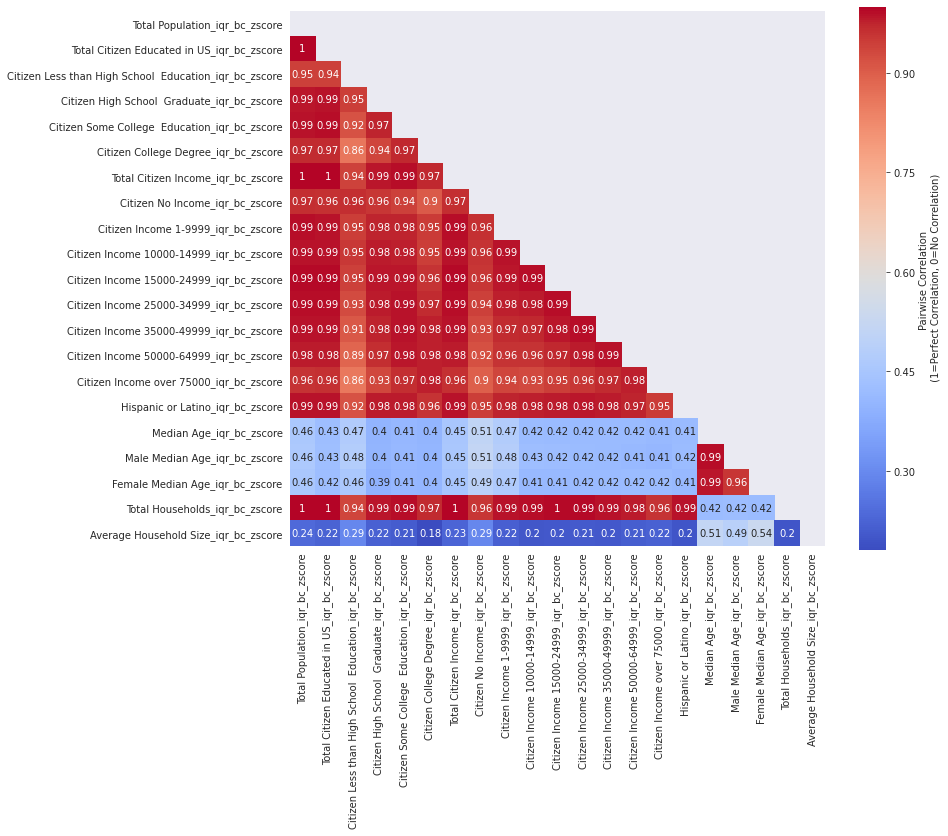

In [42]:
# Create a heatmap from our Pearson's correlation matrix
# source: https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("darkgrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    # plot a seaborn heatmap with labels inside (annot=True), a title for the bar (cbar_kws) and colorstyle (cmap)
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=1, square=True, annot=True, cbar_kws={'label': 'Pairwise Correlation \n (1=Perfect Correlation, 0=No Correlation)'}, cmap="coolwarm")

In [ ]:
# how to drop one of the pairs from the highly corr pairing and creat a new csv file
df_final =
# have to add the 2 categorical features 

<a id = "66"> <h2> 5. Save Top Features and Target Dataset to a CSV File </h2> </a>

In [51]:
# save a copy of the dataframe under 'df_calculation'
# define name of the csv file
file_name = 'final_data.csv'

# export pandas dataframe to csv
df_final.to_csv('../Capstone-Project/' + file_name, index=False)